In [1]:
import tensorflow as tf
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

def extract_fileImg(list_paths,batch_val=0,batch_test=0):
    
    labels=[]
    label_names=[]
    batch=1000
    
    image_files = tf.io.gfile.glob(list_paths)
    
    for img_path in image_files:
        if img_path.split('.')[1].split('/')[2] == "cat":
            labels.append(1)
            label_names.append("cat")
        else :
            labels.append(0)
            label_names.append("dog")
    
    if batch_val > 0:
        image_files = image_files[batch:batch+batch_val]
        labels = labels[batch:batch+batch_val]
        label_names[batch:batch+batch_val]
    if batch_test > 0:
        batch_val = 100
        image_files = image_files[batch+batch_val:batch+batch_val+batch_test]
        labels = labels[batch+batch_val:batch+batch_val+batch_test]
        label_names[batch+batch_val:batch+batch_val+batch_test]
    else:
        image_files = image_files[:batch]
        labels = labels[:batch]
        label_names = label_names[:batch]
            
    return image_files,labels,label_names

In [3]:
def preprocess_image(img_path):
    img_data = tf.io.read_file(img_path)
    feat = tf.image.decode_jpeg(img_data,channels=3)
    feat = tf.image.convert_image_dtype(feat,tf.float32)
    feat = tf.image.resize(feat,(128,128))
    return feat
    

In [4]:
# Processus DataSet-TRAIN
file_pattern = ["./train/*.jpg"]
image_files,label_train,label_name_train = extract_fileImg(file_pattern)
image_train = np.array([preprocess_image(i).numpy() for i in image_files])
dataset_train = tf.data.Dataset.from_tensor_slices((image_train,tf.cast(label_train,tf.float32))).shuffle(1000).batch(100)
dataset_train


<BatchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.float32)>

In [5]:
# Processus DataSet-VAL
file_pattern = ["./train/*.jpg"]
image_files,label_val,label_name_val = extract_fileImg(file_pattern,batch_val=100)
image_val = np.array([preprocess_image(i).numpy() for i in image_files])
dataset_val = tf.data.Dataset.from_tensor_slices((image_val,tf.cast(label_val,tf.float32))).shuffle(100).batch(10)
dataset_val

<BatchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.float32)>

In [6]:
# Processus DataSet-TEST
file_pattern = ["./train/*.jpg"]
image_files,label_test,label_name_test= extract_fileImg(file_pattern,batch_test=100)
image_test = np.array([preprocess_image(i).numpy() for i in image_files])
dataset_test = tf.data.Dataset.from_tensor_slices((image_test,tf.cast(label_test,tf.float32))).shuffle(100).batch(10)
dataset_test

<BatchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.float32)>

In [8]:
model = tf.keras.models.Sequential([

    #block 1
    tf.keras.layers.Conv2D(6, kernel_size=(5,5), activation='relu',padding='same',input_shape=(128,128,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    #block 2
    tf.keras.layers.Conv2D(16, kernel_size=(5,5), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    #Dense layers:
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120,activation='relu'),
    tf.keras.layers.Dense(84,activation='relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2,activation="softmax")
                                
])

model.compile(loss= tf.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
              metrics=["accuracy"])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 128, 128, 6)       456       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 16)        2416      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14400)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               1728120   
_________________________________________________________________
dense_4 (Dense)              (None, 84)               

In [9]:
callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=100, monitor='val_loss'), 
    #tf.keras.callbacks.TensorBoard(log_dir='/home/malloc/logs/fit1', write_graph=True)
           ]

model.fit(dataset_train, epochs=5, callbacks=callbacks,validation_data=dataset_val)

Epoch 1/5
10/10 [==============================] - 15s 1s/step - loss: 0.7072 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 10s 1s/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
10/10 [==============================] - 10s 1s/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
10/10 [==============================] - 10s 1s/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
10/10 [==============================] - 10s 1s/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000


In [10]:

model.evaluate(dataset_test)


10/10 [==============================] - 1s 51ms/step - loss: 0.6932 - accuracy: 0.5000


[0.6931817054748535, 0.5]

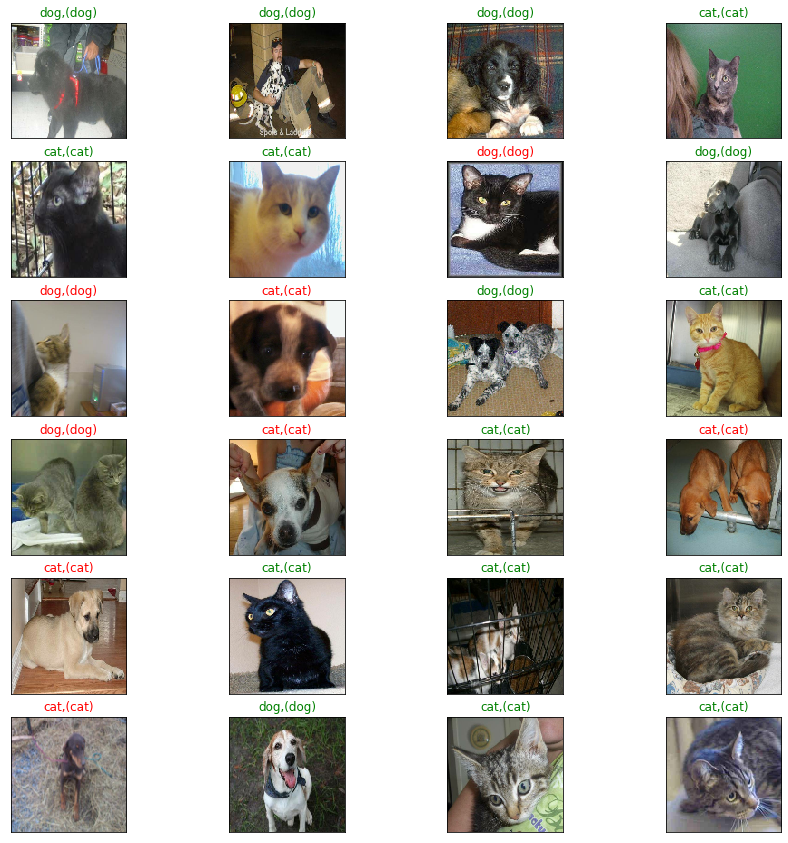

In [11]:

y_predict = model.predict(dataset_test)
size=24
rows=8
cols=4
fig = plt.figure(figsize=(15,20))
for i,index in enumerate(np.random.choice(image_test.shape[0],size=size,replace=False)):
    axis = fig.add_subplot(rows,cols,i+1,xticks=[],yticks=[])
    axis.imshow(image_test[index])
    index_p = np.argmax(y_predict[index])
    index_t = int(label_test[index])
    axis.set_title(("{},({})").format(label_name_test[index_p],label_name_test[index_p]), color=("green" if index_p==index_t else "red"))
    
